In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12,8)
plt.style.use('fivethirtyeight')

from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit, cross_val_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay, auc, roc_curve, RocCurveDisplay

import warnings
warnings.filterwarnings('ignore')

import pandas_ta as ta

import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=True)

import seaborn as sns
import plotly.graph_objs as go  
import yfinance as yf
import plotly.offline as pyo

pyo.init_notebook_mode(connected=True)

In [3]:
df1 = yf.download('^SET.BK', start='2010-01-01', end='2024-12-31',)[2:]
df1.columns = [x[0] for x in df1.columns]
df1.to_csv('Data/set.bk.csv')

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [4]:
display(df1.head())

Close        High         Low        Open   Volume
Date                                                               
2010-01-06  735.729980  737.119995  732.659973  734.729980  3696400
2010-01-07  734.630005  740.909973  733.750000  738.770020  3693600
2010-01-08  738.960022  740.909973  736.030029  736.289978  2693600
2010-01-11  746.950012  748.020020  742.719971  743.080017  3186800
2010-01-12  745.239990  749.239990  745.150024  745.530029  3455500

In [5]:
list_of_stock = ['PTT.BK','KBANK.BK','RATCH.BK', 'EGCO.BK', 'PTTEP.BK','BBL.BK']
df2 = yf.download(list_of_stock, start='2005-01-01', end='2024-12-31')['Close']

[*********************100%***********************]  6 of 6 completed


In [6]:
display(df2.head())

Ticker         BBL.BK    EGCO.BK   KBANK.BK    PTT.BK   PTTEP.BK   RATCH.BK
Date                                                                       
2005-01-04  54.801086  31.013975  31.108465  7.354320  13.256137  13.328572
2005-01-05  54.801086  31.622078  30.828220  7.312533  13.256137  13.328572
2005-01-06  56.309349  32.027489  31.388737  7.437891  13.256137  13.500550
2005-01-07  55.806595  31.824785  31.668987  7.437891  13.256137  13.758527
2005-01-10  55.806595  31.419392  31.668987  7.479679  13.256137  13.758527

In [7]:
df2.normalize().iplot(kind='line')

In [8]:
df3 = df2.pct_change()

<Axes: xlabel='Ticker', ylabel='Ticker'>

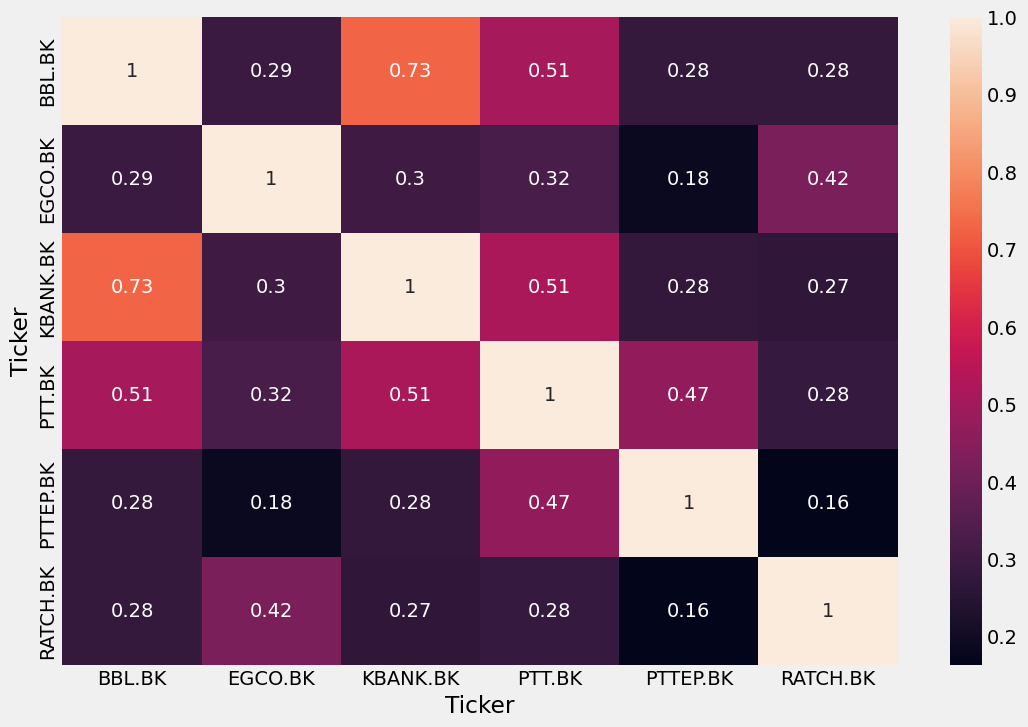

In [9]:
sns.heatmap(df3.corr(), annot=True)

In [10]:
df3.describe().T

count      mean       std       min       25%  50%       75%  \
Ticker                                                                    
BBL.BK    4894.0  0.000342  0.016984 -0.162601 -0.008621  0.0  0.009029   
EGCO.BK   4894.0  0.000367  0.014301 -0.145299 -0.006667  0.0  0.007143   
KBANK.BK  4894.0  0.000502  0.019342 -0.184397 -0.009346  0.0  0.009828   
PTT.BK    4894.0  0.000471  0.018948 -0.253333 -0.008772  0.0  0.008929   
PTTEP.BK  4894.0  0.000829  0.033455 -0.298122 -0.009524  0.0  0.009732   
RATCH.BK  4894.0  0.000265  0.014562 -0.152838 -0.006250  0.0  0.006369   

               max  
Ticker              
BBL.BK    0.108225  
EGCO.BK   0.104651  
KBANK.BK  0.170807  
PTT.BK    0.161290  
PTTEP.BK  1.795181  
RATCH.BK  0.245614

In [11]:
fig = df3.iplot(kind='histogram',
          subplots=True,
          shared_xaxes=True,
          asFigure = True,
          )

for i in range(1, len(df3.columns) + 1):
    fig['layout'].update({f'xaxis{i}': {'range': [-0.2, 0.2]}})

pyo.iplot(fig)

In [12]:
layout = go.Layout(
        xaxis=dict(
            range=[-0.5, 0.5]
        )
    )

df3.iplot(kind='histogram', layout = layout)

In [13]:
layout = go.Layout(
        yaxis=dict(
            range=[-0.5, 0.5]
        )
    )

df3.iplot(kind='box', layout=layout)

In [14]:
#yearly volatility
print(df3.std() * np.sqrt(252) * 100)

Ticker
BBL.BK      26.961824
EGCO.BK     22.702268
KBANK.BK    30.704903
PTT.BK      30.078903
PTTEP.BK    53.108495
RATCH.BK    23.116479
dtype: float64


## Starting to using model for predicting the next period return

In [15]:
df = df1.copy()
df['Close'].iplot(kind='line')

In [16]:
df['Forward Returns'] = np.log(df['Close']).diff().shift(-1)

In [17]:
df.dropna(inplace=True)
df.head()

Close        High         Low        Open   Volume  \
Date                                                                  
2010-01-06  735.729980  737.119995  732.659973  734.729980  3696400   
2010-01-07  734.630005  740.909973  733.750000  738.770020  3693600   
2010-01-08  738.960022  740.909973  736.030029  736.289978  2693600   
2010-01-11  746.950012  748.020020  742.719971  743.080017  3186800   
2010-01-12  745.239990  749.239990  745.150024  745.530029  3455500   

            Forward Returns  
Date                         
2010-01-06        -0.001496  
2010-01-07         0.005877  
2010-01-08         0.010754  
2010-01-11        -0.002292  
2010-01-12         0.002011

In [18]:
df.describe()

Close         High          Low         Open        Volume  \
count  3641.000000  3641.000000  3641.000000  3641.000000  3.641000e+03   
mean   1423.130022  1430.531146  1416.019796  1424.085882  8.350230e+06   
std     243.531682   243.926229   243.538164   244.005284  5.227510e+06   
min     685.890015   688.140015   679.450012   685.010010  0.000000e+00   
25%    1307.709961  1315.699951  1301.140015  1308.459961  4.262100e+06   
50%    1490.140015  1497.640015  1482.869995  1491.050049  7.344600e+06   
75%    1595.329956  1603.010010  1588.040039  1597.000000  1.105240e+07   
max    1838.959961  1852.510010  1831.150024  1843.300049  5.294150e+07   

       Forward Returns  
count      3641.000000  
mean          0.000177  
std           0.009922  
min          -0.114282  
25%          -0.004421  
50%           0.000488  
75%           0.005112  
max           0.076531

In [19]:
# Feature Engineering
df['O-C'] = df.Open - df.Close
df['H-L'] = df.High - df.Low
df['5day MA'] = df.Close.rolling(window=3).mean()
df['10day MA'] = df.Close.rolling(window=10).mean()
df['30day MA'] = df.Close.rolling(window=30).mean()
df['Std_dev'] = df.Close.rolling(window=20).std()
df['RSI'] = ta.rsi(df.Close, window=14)
df.dropna(inplace=True) 

In [20]:
X=df.drop(['Close','Forward Returns'], axis=1)
y=np.where(df['Forward Returns']>=0,1,0)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

print(f"Train and Test Size {len(X_train)}, {len(X_test)}")

Train and Test Size 2889, 723


In [ ]:
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

#scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

xgb = XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42)
xgb.fit(X_train_scaled, y_train)
y_pred = xgb.predict(X_test_scaled)
acc_train = accuracy_score(y_train, xgb.predict(X_train_scaled))
acc_test = accuracy_score(y_test, y_pred)
print(f'Train Accuracy: {acc_train:0.4}, Test Accuracy: {acc_test:0.4}')

Train Accuracy: 0.6964, Test Accuracy: 0.5325


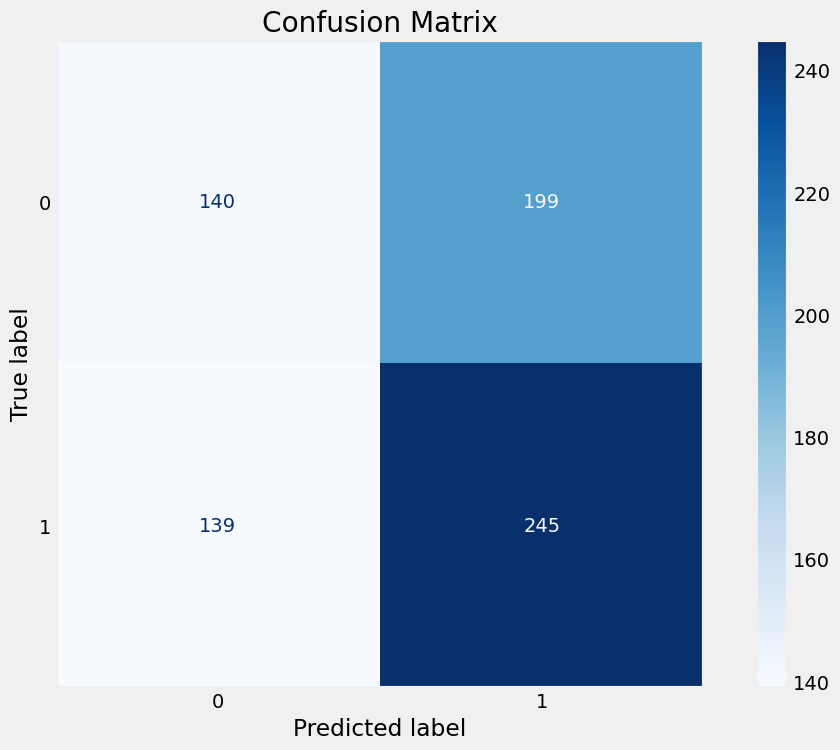

In [39]:
ConfusionMatrixDisplay.from_estimator(xgb, X_test_scaled, y_test, cmap='Blues', values_format='.4g')
plt.title('Confusion Matrix')
plt.grid(False)

In [40]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.50      0.41      0.45       339
           1       0.55      0.64      0.59       384

    accuracy                           0.53       723
   macro avg       0.53      0.53      0.52       723
weighted avg       0.53      0.53      0.53       723



(0.0, 1.05)

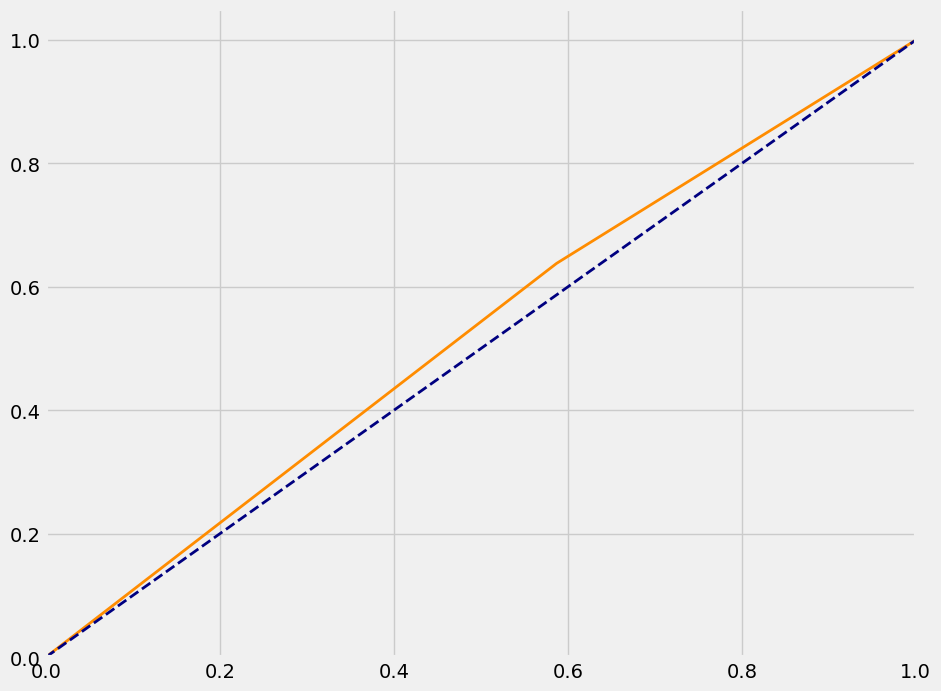

In [41]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

In [44]:
tscv = TimeSeriesSplit(n_splits=3, gap=1)
for train, test in tscv.split(X):
    continue

In [45]:
tscv = TimeSeriesSplit(n_splits=5, gap=1)
pipe.get_params()